In [1]:
import csv
import numpy as np
import requests

## Load final table

In [2]:
with open("./group_data_by_users.csv", "r") as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")

    table_grouped = [row for row in reader_variable]

## Training of Outlier indentifier Model

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
 
table_grouped_array = np.array(table_grouped)
user_ids = table_grouped_array[1:,0]
X = table_grouped_array[1:,1:].astype(float)


X_train, X_test, users_train, users_test = train_test_split(X, user_ids, test_size=0.5, random_state=42)

clf = IsolationForest(random_state=0).fit(X_train)

predictions = clf.predict(X_test)
scores = clf.score_samples(X_test)*-1

predictions_classes = []

for i in predictions:    
    if i == 1:
        predictions_classes.append("nonfraud")
    else:
        predictions_classes.append("fraud")

## Send Scores to database

In [4]:
data_scores = {"id":users_test.tolist(),
               "outlier_prob":scores.tolist(),
               "class_pred":predictions_classes,
               "project_name":"raizen_gasoline",
               "table_name":"fraud"}


url = "http://0.0.0.0:5000/insert"

response = requests.post(url, json=data_scores)
print(response)

<Response [200]>


## Exploratory Analysis 

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df_analysis = pd.DataFrame({"id":users_test.tolist(),
                "outlier_prob":scores.tolist(),
                "class_pred":predictions_classes,
                table_grouped_array[0,1]:X_test[:,0].astype(float),
                table_grouped_array[0,2]:X_test[:,1].astype(float),
                table_grouped_array[0,3]:X_test[:,2].astype(float)})

df_analysis.head()

,id,outlier_prob,class_pred,total_liters,total_amount_paid,is_premium
0,6625,0.388297,nonfraud,553.0,42.854766,0.0
1,5213,0.400981,nonfraud,531.0,41.226099,0.0
2,2556,0.416202,nonfraud,645.0,63.169030,0.0
3,5266,0.664895,fraud,1050.0,43.202179,1.0
4,5067,0.421722,nonfraud,776.0,71.395915,0.0


## Plot Parameters

In [31]:
colors = ["red","yellow","black","green","blue"]
n_bins = 100

## Distribution of predict variables

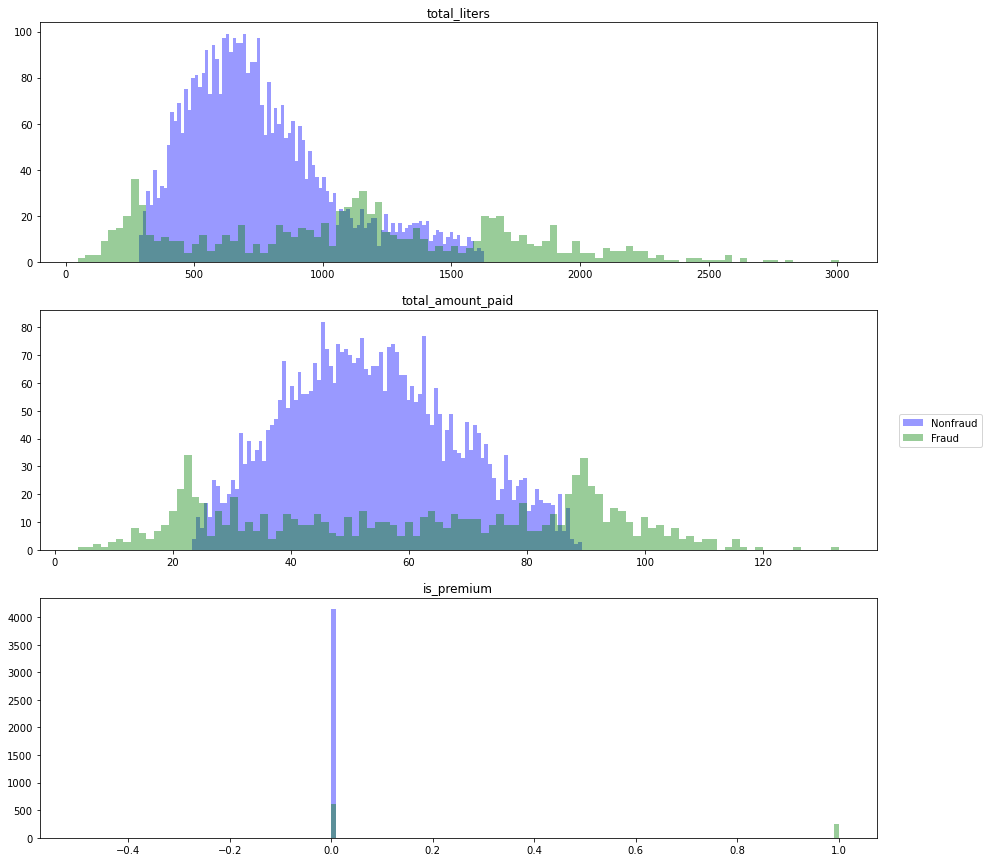

In [44]:
f, axes = plt.subplots(3, 1,figsize=(15,15))

sns.distplot(df_analysis[df_analysis['class_pred']=='nonfraud']['total_liters'].values, bins=n_bins, kde=False,label='Nonfraud',color=colors[4],ax=axes[0]).set_title("total_liters")
sns.distplot(df_analysis[df_analysis['class_pred']=='fraud']['total_liters'].values, bins=n_bins, kde=False,label='Fraud',color=colors[3],ax=axes[0]).set_title("total_liters")



sns.distplot(df_analysis[df_analysis['class_pred']=='nonfraud']['total_amount_paid'].values, bins=n_bins, kde=False,label='Nonfraud',color=colors[4],ax=axes[1]).set_title("total_amount_paid")
sns.distplot(df_analysis[df_analysis['class_pred']=='fraud']['total_amount_paid'].values, bins=n_bins, kde=False,label='Fraud',color=colors[3],ax=axes[1]).set_title("total_amount_paid")


sns.distplot(df_analysis[df_analysis['class_pred']=='nonfraud']['is_premium'].values, bins=n_bins, kde=False,label='Nonfraud',color=colors[4],ax=axes[2]).set_title("is_premium")
sns.distplot(df_analysis[df_analysis['class_pred']=='fraud']['is_premium'].values, bins=n_bins, kde=False,label='Fraud',color=colors[3],ax=axes[2]).set_title("is_premium")


lines, labels = f.axes[-1].get_legend_handles_labels()
    
f.legend(lines, labels, loc = 'right')

plt.show()

## Boxplot of total_liters and total_amount_paid

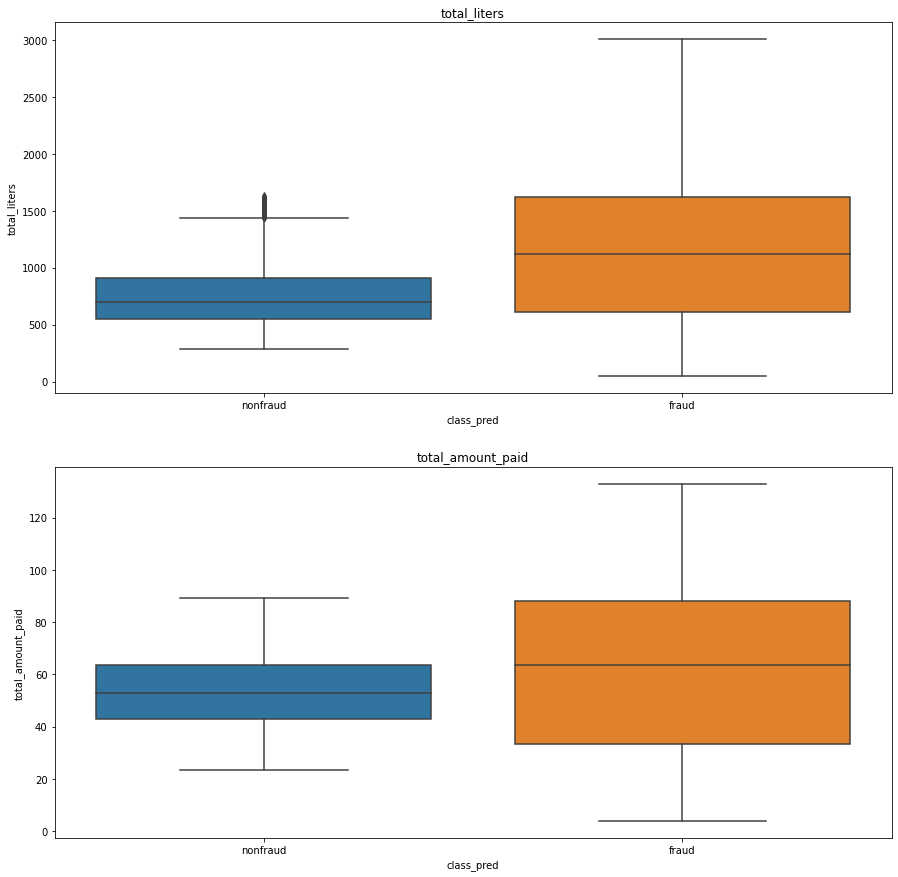

In [61]:
f, axes = plt.subplots(2, 1,figsize=(15,15))

ax = sns.boxplot(x="class_pred", y="total_liters", data=df_analysis,ax=axes[0],order=['nonfraud', 'fraud']).set_title("total_liters")

ax = sns.boxplot(x="class_pred", y="total_amount_paid", data=df_analysis,ax=axes[1],order=['nonfraud', 'fraud']).set_title("total_amount_paid")


## Observations

- the median, maximum and minimum of the variables total_amout_paid and total_liters for customers predicted as fraud are quite discrepant when compared to customers predicted as not fraud, as we can see in the boxplots.



- The distributions of variables total liters, total amount of customers predicted as non-fraudulent have the shape of a normal distribution, whereas customers predicted as fraudulent have distributions well distributed in small and high values.


- the model is considering all premiuns as fraud, as we can see in the histogram above, but considering that the model identifies outliers and premium customers are exclusive and have a specific behavior, this is expected to happen because it is quite different from most other customers. A possible treatment for version 2 of this model is to create a segmentation for these premium customers.